In [1]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import itertools
from scipy import stats
import pandas as pd
import seaborn as sns
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from skbio.stats.composition import ilr, clr
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from scipy.stats import chi2

from statsmodels.stats.multitest import fdrcorrection

from src.models.outliers import outlier_detection, logratio_outlier_detection, impute_zero_values
from src.visualization.plots import biplot, screeplot, loadingsplot, psuedocontrolcomparisonplot
from src.config import get_interim_dir, get_experiment_artifacts
from src.config import get_hussmann_supplementary_xlsx, HOME_PATH, FILTER_COUNT, METHOD, SAMPLE, PROFILE_TYPE


In [3]:
print(FILTER_COUNT, METHOD, PROFILE_TYPE)

700 robust_cov paired-replicates


In [4]:
FILTER_COUNT, METHOD, SAMPLE

(700, 'robust_cov', 'sample')

In [5]:
aliases = ["MB0{}".format(i) for i in range(1, 7)]

<AxesSubplot:xlabel='Number of barcodes with zero counts', ylabel='Alias'>

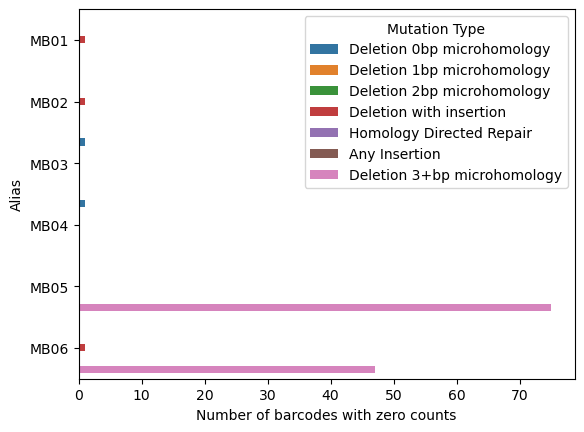

In [6]:
data = {}
for alias in aliases:
    X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.{}.pkl".format(alias, FILTER_COUNT))
    data[alias] = (X == 0).sum()

plot_d = pd.concat(data).reset_index().rename(columns={"level_0": "Alias", 0: "Number of barcodes with zero counts", "lumc_category": "Mutation Type"})
sns.barplot(data=plot_d, y="Alias", x="Number of barcodes with zero counts", hue="Mutation Type")

In [7]:
X.shape

(78037, 7)

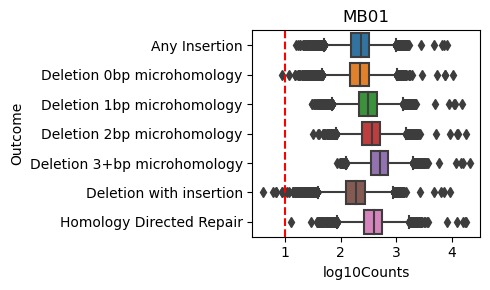

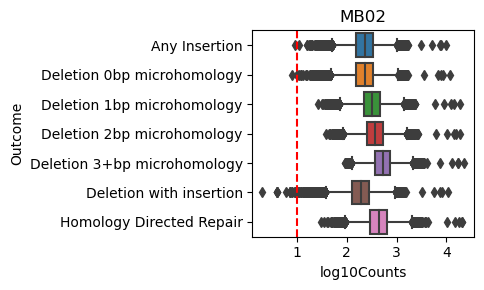

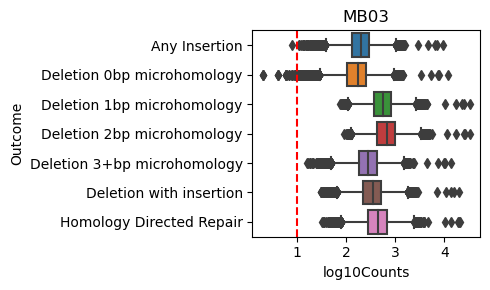

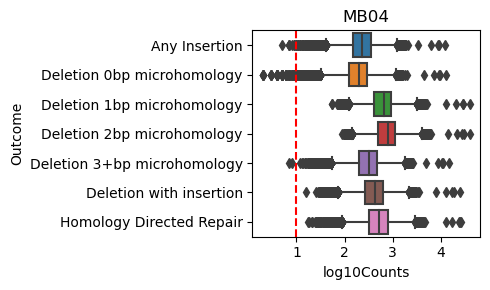

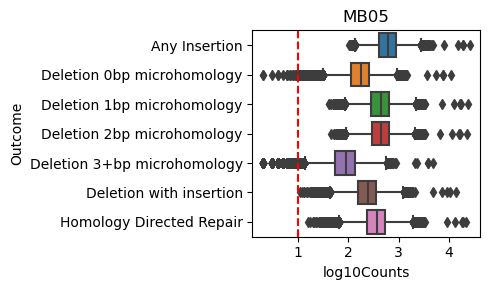

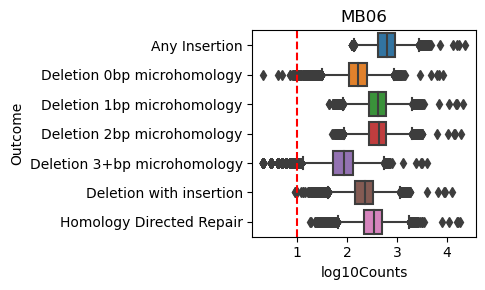

In [8]:
for alias in aliases: 
    X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.{}.pkl".format(alias, FILTER_COUNT))
    X = X.loc[~(X==0).any(axis=1)]
    X.columns.name = "Outcome"
    X.head()
    X = X.loc[:, (X != 0).any(axis=0)]
    plt.figure(figsize=(5, 3))
    boxplot_data = np.log10(X.sort_index(axis=1).stack()).reset_index().rename(columns={0: "log10Counts"})
    boxplot_data["log10median <= 1"] = boxplot_data.groupby("Outcome").median()["log10Counts"] <= 1
    sns.boxplot(data=boxplot_data, y="Outcome", x="log10Counts")
    plt.axvline(1, ls="--", color="red")
    plt.title(alias)
    plt.tight_layout()
    plt.savefig("{}/countsperfeature.{}.png".format(get_experiment_artifacts(profile_type=SAMPLE), alias))
    plt.show()


In [9]:
X.head()

Outcome                                     Deletion 0bp microhomology  \
Target Alias Gene          Barcode                                       
T3     MB06  0610009B22Rik 0610009B22Rik-1                       224.0   
                           0610009B22Rik-2                       221.0   
                           0610009B22Rik-3                       335.0   
                           0610009B22Rik-4                       401.0   
                           0610009B22Rik-5                       351.0   

Outcome                                     Deletion 1bp microhomology  \
Target Alias Gene          Barcode                                       
T3     MB06  0610009B22Rik 0610009B22Rik-1                       531.0   
                           0610009B22Rik-2                       721.0   
                           0610009B22Rik-3                       821.0   
                           0610009B22Rik-4                       900.0   
                           0610009B22Rik-5                       553.0   

Outcome                                     Deletion 2bp microhomology  \
Target Alias Gene          Barcode                                       
T3     MB06  0610009B22Rik 0610009B22Rik-1                       409.0   
                           0610009B22Rik-2                       737.0   
                           0610009B22Rik-3                       693.0   
                           0610009B22Rik-4                       775.0   
                           0610009B22Rik-5                       469.0   

Outcome                                     Deletion with insertion  \
Target Alias Gene          Barcode                                    
T3     MB06  0610009B22Rik 0610009B22Rik-1                    333.0   
                           0610009B22Rik-2                    441.0   
                           0610009B22Rik-3                    394.0   
                           0610009B22Rik-4                    368.0   
                           0610009B22Rik-5                    173.0   

Outcome                                     Homology Directed Repair  \
Target Alias Gene          Barcode                                     
T3     MB06  0610009B22Rik 0610009B22Rik-1                     402.0   
                           0610009B22Rik-2                     587.0   
                           0610009B22Rik-3                     648.0   
                           0610009B22Rik-4                     972.0   
                           0610009B22Rik-5                     496.0   

Outcome                                     Any Insertion  \
Target Alias Gene          Barcode                          
T3     MB06  0610009B22Rik 0610009B22Rik-1          603.0   
                           0610009B22Rik-2          792.0   
                           0610009B22Rik-3         1017.0   
                           0610009B22Rik-4         1145.0   
                           0610009B22Rik-5          575.0   

Outcome                                     Deletion 3+bp microhomology  
Target Alias Gene          Barcode                                       
T3     MB06  0610009B22Rik 0610009B22Rik-1                         50.0  
                           0610009B22Rik-2                        131.0  
                           0610009B22Rik-3                        145.0  
                           0610009B22Rik-4                        191.0  
                           0610009B22Rik-5                        106.0

In [10]:
X_orig = {}
X_imputed = {}
counts = {}

for alias in aliases:
    X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.{}.pkl".format(alias, FILTER_COUNT))
    X = X.loc[:, (X != 0).any(axis=0)]
    print((X>0).sum().sum() / (X.shape[0] * X.shape[1]))

    counts[alias] = X.sum(axis=1)

    X_orig[alias] = X

    X = impute_zero_values(X, 1)
    columns = X.columns
    # X = X.div(X.sum(axis=1), axis=0)
    X = X.groupby(["Gene"]).apply(stats.gmean)
    X = pd.DataFrame(X.values.tolist(), index=X.index, columns=columns)
    X = X.div(X.sum(axis=1), axis=0)
    X.columns = columns

    X_imputed[alias] = X
    print(X_imputed[alias].shape)

print("Data Ready.")

0.9999976571194283
0.00 of our data is zero
(17004, 7)
0.9999977448475404
0.00 of our data is zero
(17135, 7)
0.9999982008143115
0.00 of our data is zero
(18089, 7)
0.9999982285898512
0.00 of our data is zero
(18140, 7)
0.9998638158790685
0.00 of our data is zero
(18133, 7)
0.9999121295942035
0.00 of our data is zero
(18092, 7)
Data Ready.


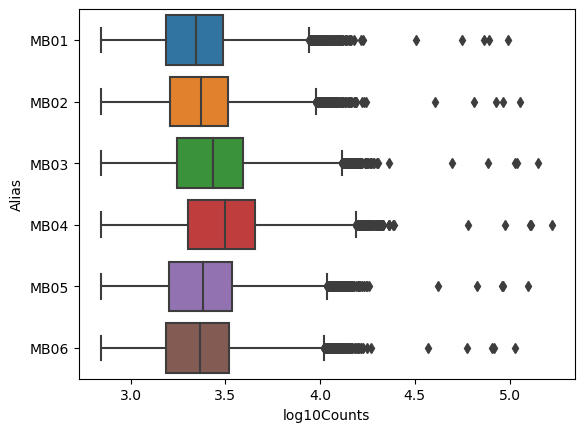

In [11]:
counts_df = pd.concat([c.reset_index().rename(columns={0: "Counts"}) for c in counts.values()])
counts_df["log10Counts"] = np.log10(counts_df["Counts"])
counts_df

sns.boxplot(data=counts_df, y="Alias", x="log10Counts")
plt.savefig("{}/countsperreplicate.png".format(get_experiment_artifacts(profile_type=SAMPLE)))

In [12]:
df = pd.concat(X_imputed, names=["Sample"]).fillna(0)
df

lumc_category         Deletion 0bp microhomology  Deletion 1bp microhomology  \
Sample Gene                                                                    
MB01   0610009B22Rik                    0.089537                    0.135059   
       0610010K14Rik                    0.099469                    0.136351   
       0610030E20Rik                    0.125854                    0.131631   
       0610040J01Rik                    0.096592                    0.136292   
       1110004F10Rik                    0.119272                    0.124494   
...                                          ...                         ...   
MB06   Zzef1                            0.084126                    0.161611   
       Zzz3                             0.072021                    0.176642   
       a                                0.085867                    0.179495   
       ccdc198                          0.077076                    0.185418   
       mei-04                           0.080616                    0.176417   

lumc_category         Deletion 2bp microhomology  Deletion with insertion  \
Sample Gene                                                                 
MB01   0610009B22Rik                    0.156208                 0.081177   
       0610010K14Rik                    0.169341                 0.087588   
       0610030E20Rik                    0.157608                 0.083250   
       0610040J01Rik                    0.197020                 0.077466   
       1110004F10Rik                    0.158365                 0.074936   
...                                          ...                      ...   
MB06   Zzef1                            0.168189                 0.101551   
       Zzz3                             0.191675                 0.101046   
       a                                0.183124                 0.098134   
       ccdc198                          0.190762                 0.091826   
       mei-04                           0.201646                 0.090488   

lumc_category         Homology Directed Repair  Any Insertion  \
Sample Gene                                                     
MB01   0610009B22Rik                  0.188857       0.105790   
       0610010K14Rik                  0.173648       0.095172   
       0610030E20Rik                  0.144923       0.095751   
       0610040J01Rik                  0.142024       0.116655   
       1110004F10Rik                  0.217054       0.084385   
...                                        ...            ...   
MB06   Zzef1                          0.168317       0.273099   
       Zzz3                           0.156457       0.267411   
       a                              0.154552       0.266641   
       ccdc198                        0.169973       0.251599   
       mei-04                         0.158912       0.255511   

lumc_category         Deletion 3+bp microhomology  
Sample Gene                                        
MB01   0610009B22Rik                     0.243373  
       0610010K14Rik                     0.238429  
       0610030E20Rik                     0.260983  
       0610040J01Rik                     0.233951  
       1110004F10Rik                     0.221493  
...                                           ...  
MB06   Zzef1                             0.043108  
       Zzz3                              0.034747  
       a                                 0.032186  
       ccdc198                           0.033346  
       mei-04                            0.036409  

[106593 rows x 7 columns]

In [13]:
# Include this code if you want to only include genes when they have valid data in BOTH replicates of a target site

def get_target(sample):
    targets = {
        "MB01": "T1",
        "MB02": "T1",
        "MB03": "T2",
        "MB04": "T2",
        "MB05": "T3",
        "MB06": "T3",
    }
    return targets[sample]


valid_data_count = df.copy()
valid_data_count["Target"] = valid_data_count.index.get_level_values("Sample").to_series().apply(get_target).values
valid_data_count = valid_data_count.reset_index().set_index(["Target", "Sample", "Gene"])
valid_target_per_genes = (valid_data_count.groupby(["Gene", "Target"]).size() == 2)
valid_genes = valid_target_per_genes.groupby(["Gene"]).sum() > 1
valid_target_per_genes = valid_target_per_genes.to_frame().rename(columns={0: "includeTarget"}).join(valid_genes.to_frame().rename(columns={0: "includeGene"})).all(axis=1)


valid_data_count = valid_data_count.join(valid_target_per_genes.to_frame().rename(columns={0: "include"}))
valid_gene_samples = valid_data_count[valid_data_count["include"]].reorder_levels([0, 2, 1]).index

for alias in aliases:
    X_orig[alias] = X_orig[alias].loc[X_orig[alias].index.droplevel("Barcode").isin(valid_gene_samples), :]
    X_imputed[alias] = X_imputed[alias].loc[X_imputed[alias].index.isin(valid_gene_samples.droplevel("Target").to_series().loc[alias].index), :]
    counts[alias] = counts[alias].loc[counts[alias].index.droplevel("Barcode").isin(valid_gene_samples), :]

### General Profiles Per Target Site

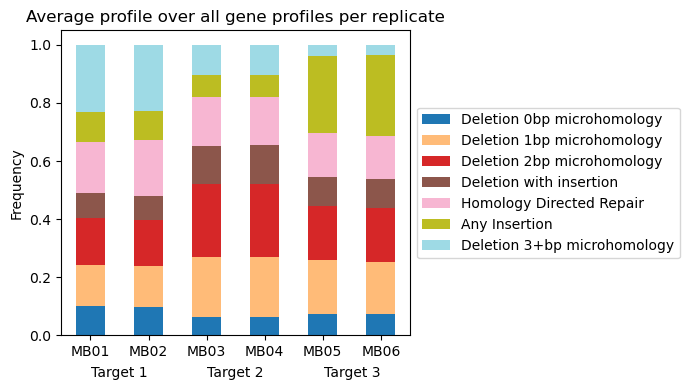

In [52]:
barplot_df = df.groupby("Sample").mean().fillna(0)
f = plt.figure(figsize=(7, 4))
ax = f.add_subplot(111)
plt.title('Average profile over all gene profiles per replicate', color='black')
# barplot_df["Target"] = ["Target 1", "Target 1", "Target 2", "Target 2", "Target 3", "Target 3"]
# barplot_df = barplot_df.reset_index().set_index(["Target", "Sample"])
barplot_df.plot(kind="bar", stacked=True, ax=f.gca(), colormap="tab20")

x = np.arange(0, 6)
ax.set_xticks(x + 0.5, minor=True)
ax.set_xticklabels(['Target 1', '', 'Target 2', '', 'Target 3', ''], minor=True)
ax.tick_params(axis='x', which='minor', length=0, pad=22)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=0)
plt.ylabel("Frequency")
plt.xlabel(None)
plt.tight_layout()
plt.savefig("{}/frequencystackedbarplot.pdf".format(get_experiment_artifacts(profile_type=SAMPLE)))

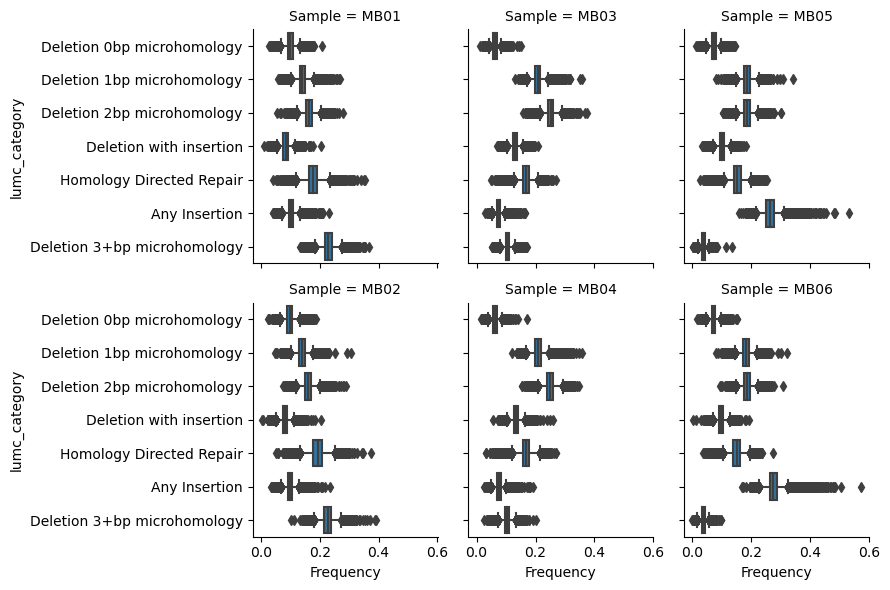

In [ ]:
facetplot_df = df.stack()
facetplot_df.name = "Frequency"
facetplot_df = facetplot_df.reset_index()
g = sns.FacetGrid(facetplot_df, col="Sample", height = 3, col_wrap=3, col_order=["MB01", "MB03", "MB05", "MB02", "MB04", "MB06" ])
g.map_dataframe(sns.boxplot, y="lumc_category", x="Frequency")
plt.savefig("{}/frequencyboxplots.{}.png".format(get_experiment_artifacts(profile_type=SAMPLE), alias))

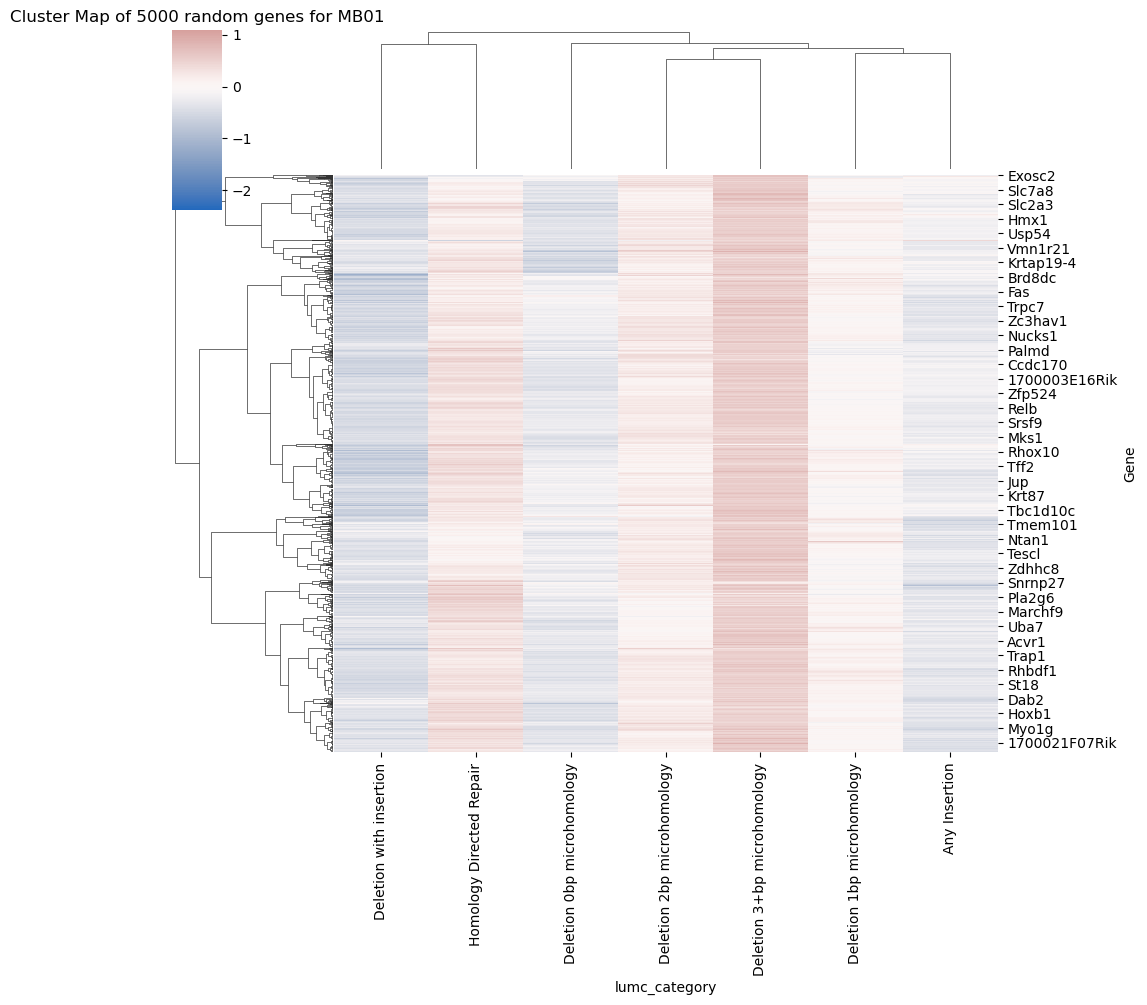

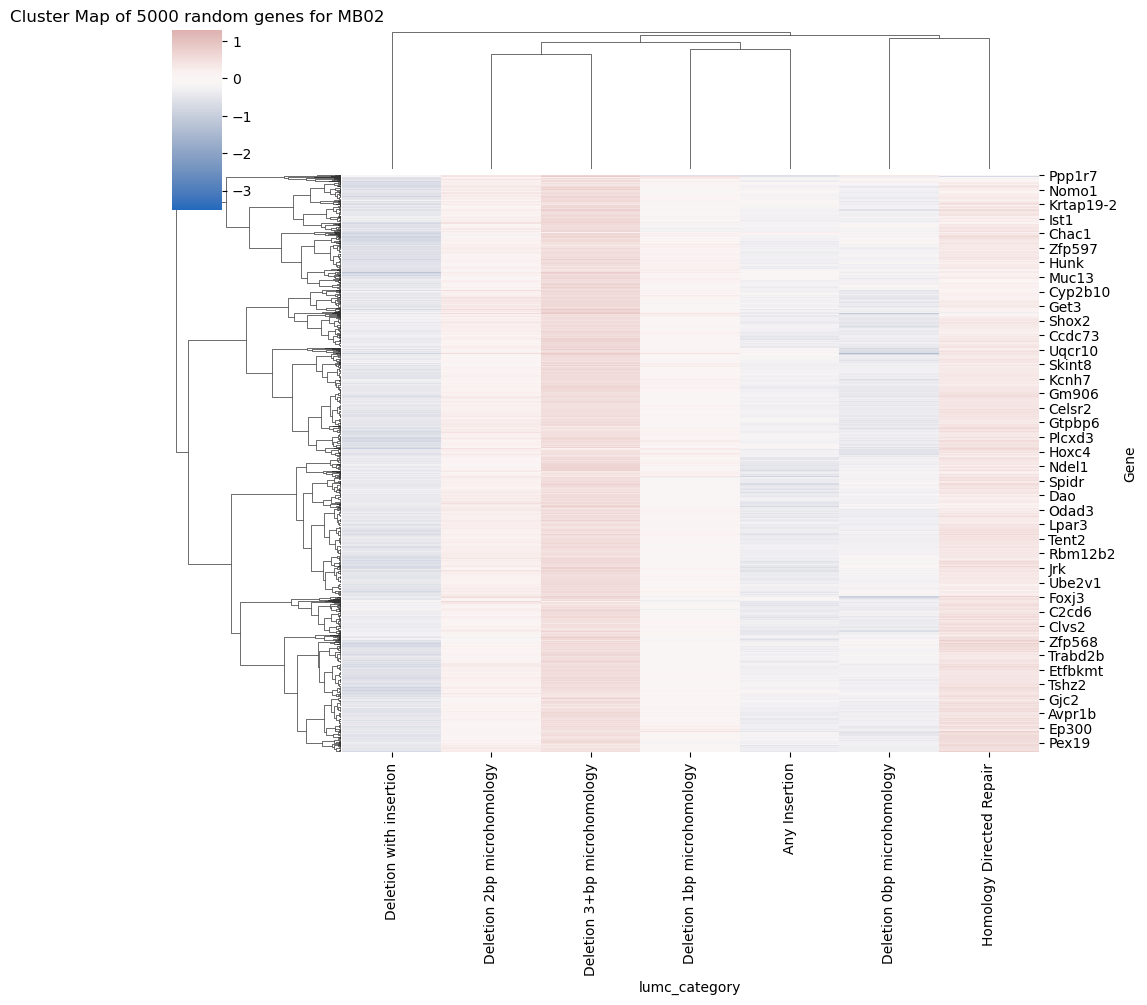

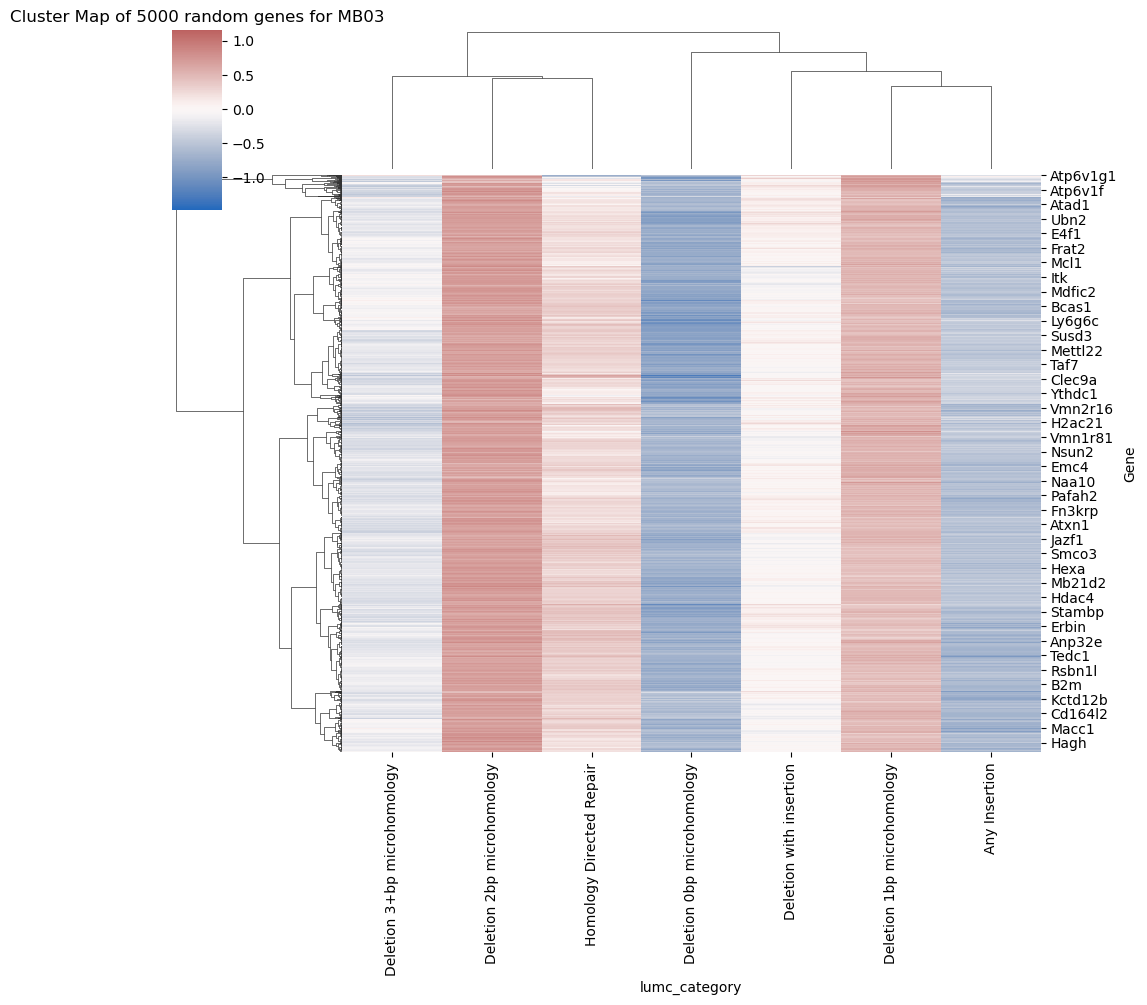

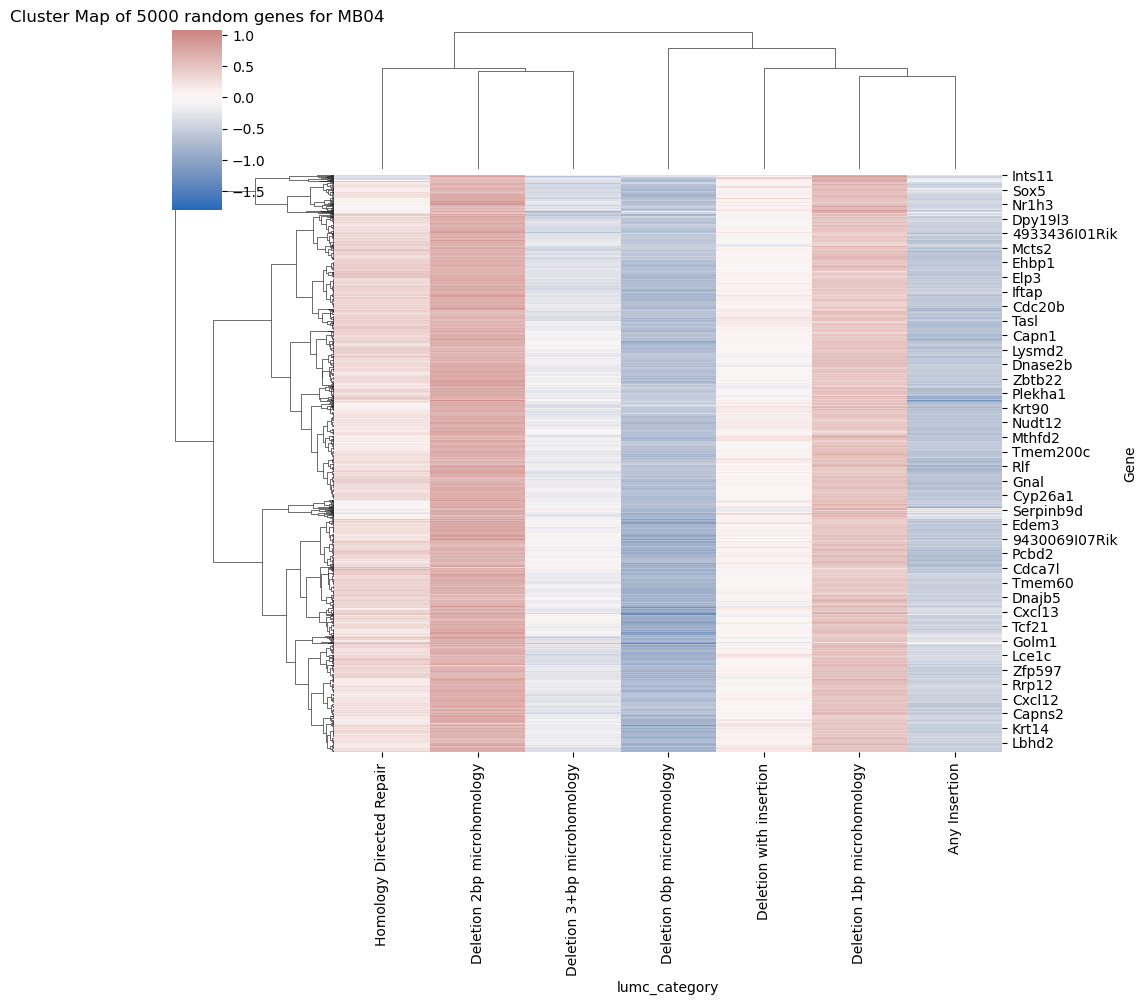

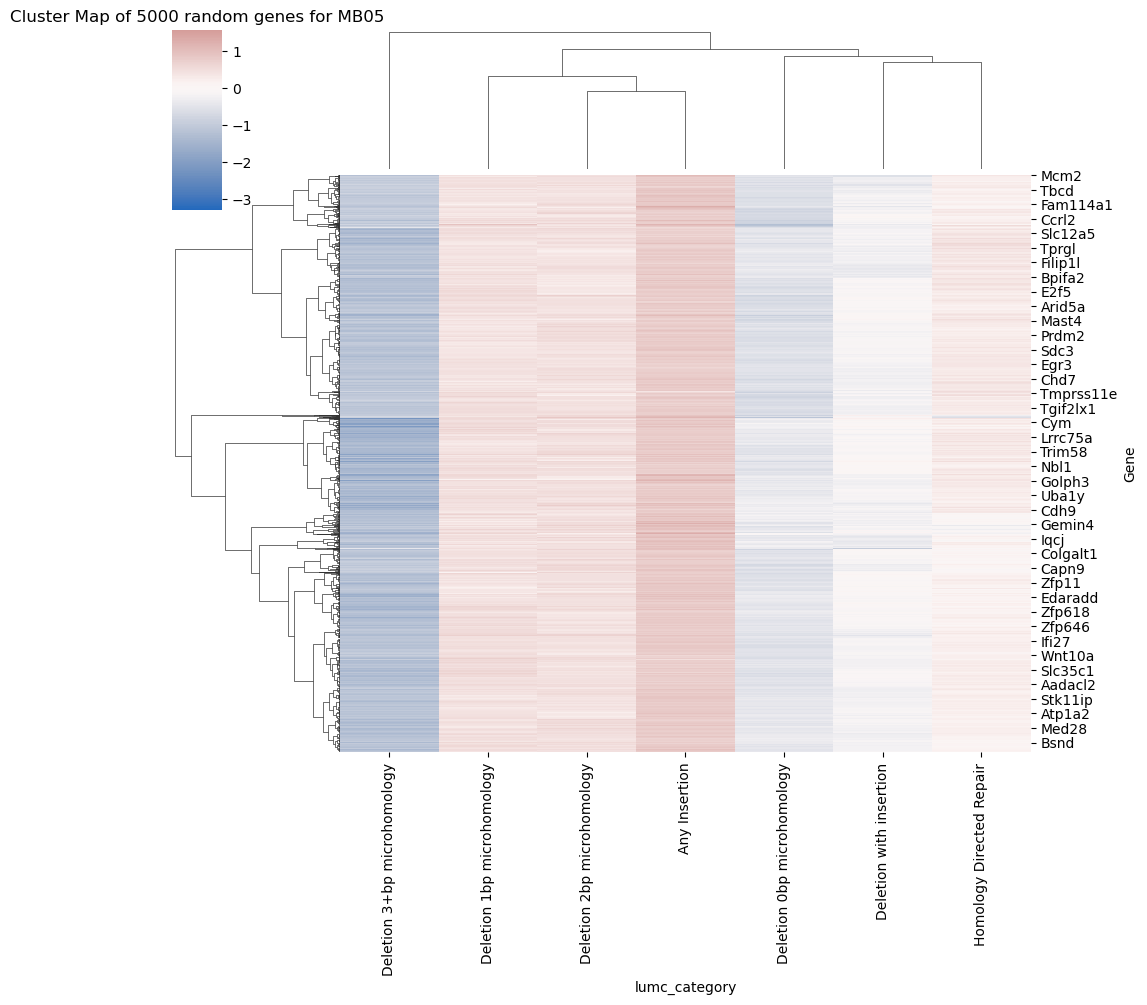

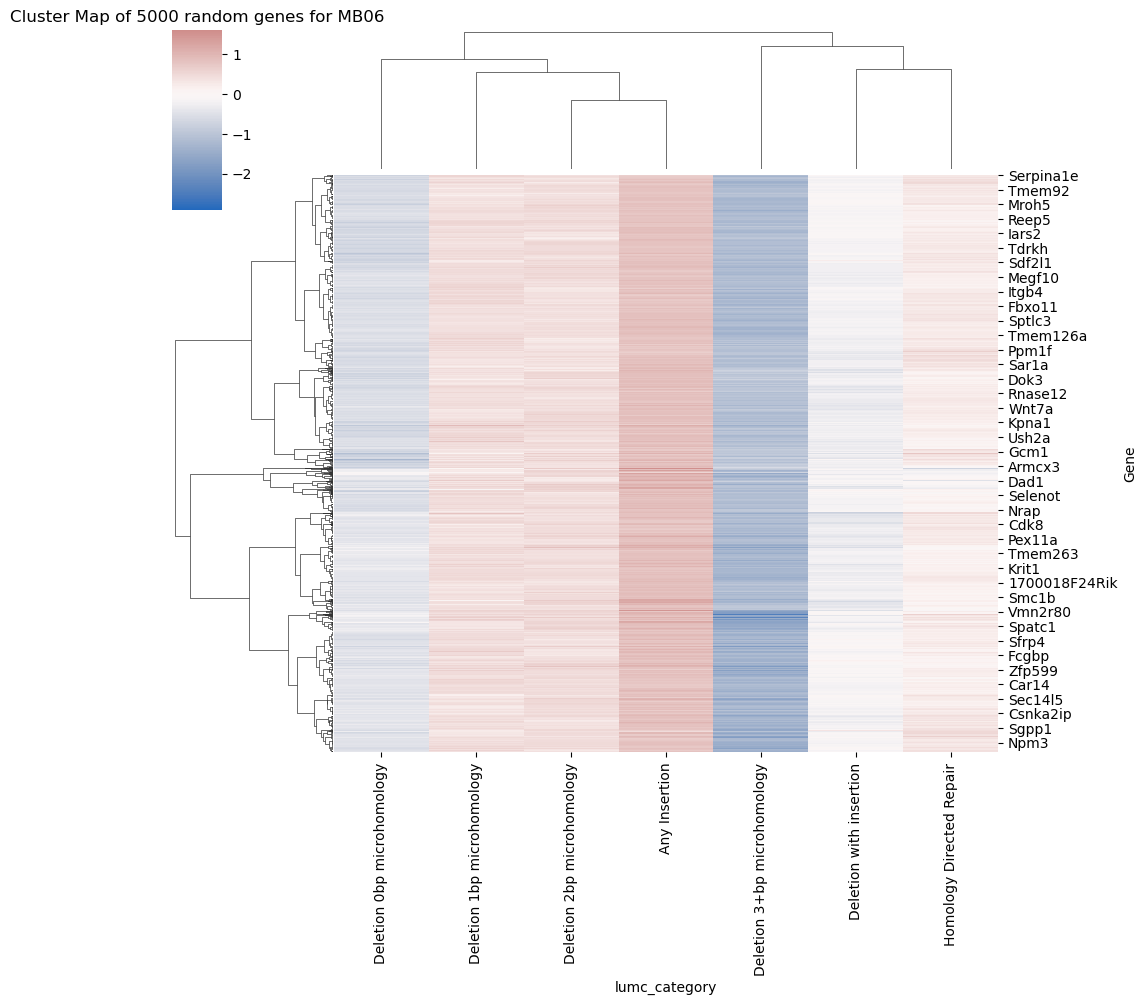

In [ ]:
for alias in aliases:
    clustermap_df = df.loc[alias,:].sample(5000)
    clustermap_df = clustermap_df.loc[:, (clustermap_df != 0).any(axis=0)]
    clustermap_df = pd.DataFrame(clr(clustermap_df), columns=clustermap_df.columns, index=clustermap_df.index)
    sns.clustermap(clustermap_df, metric="correlation", center=0, cmap="vlag", method="ward")
    plt.title("Cluster Map of 5000 random genes for {}".format(alias))
    plt.savefig("{}/clustermap.{}.png".format(get_experiment_artifacts(profile_type=SAMPLE), alias))

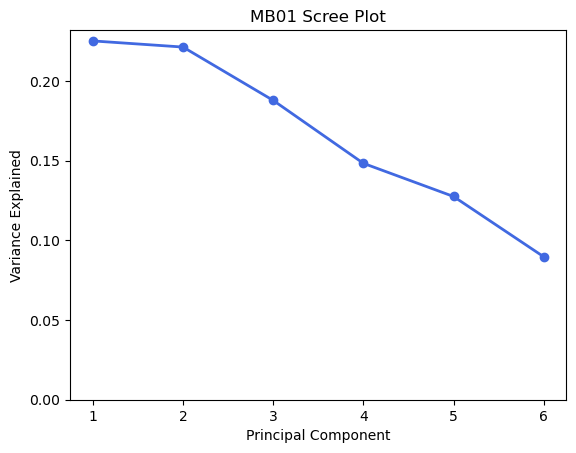

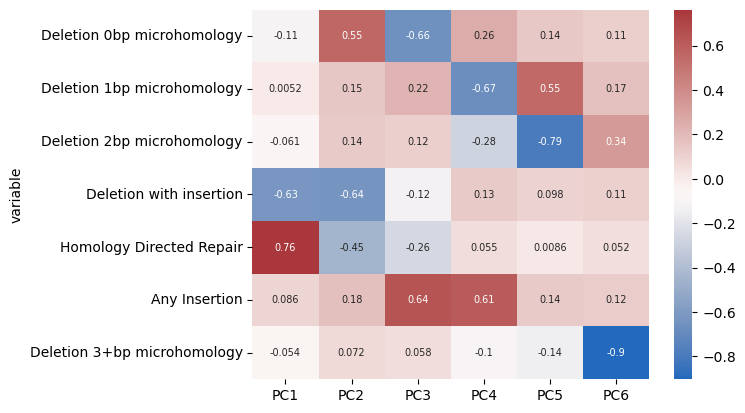

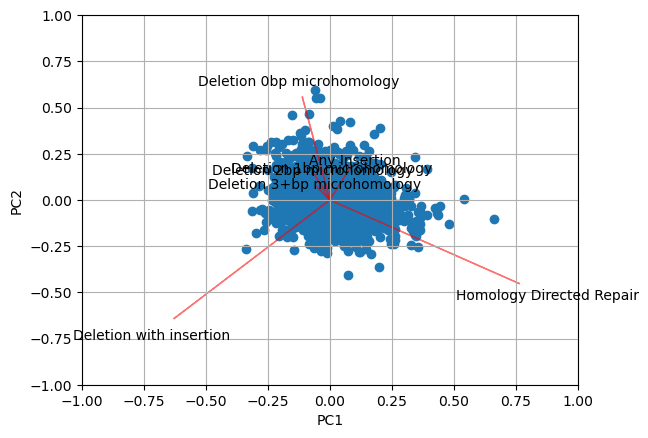

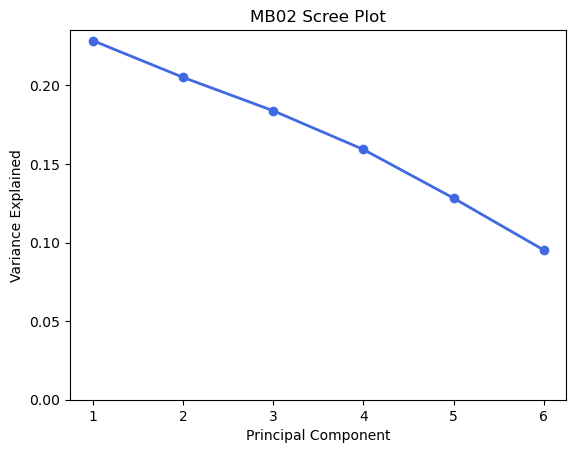

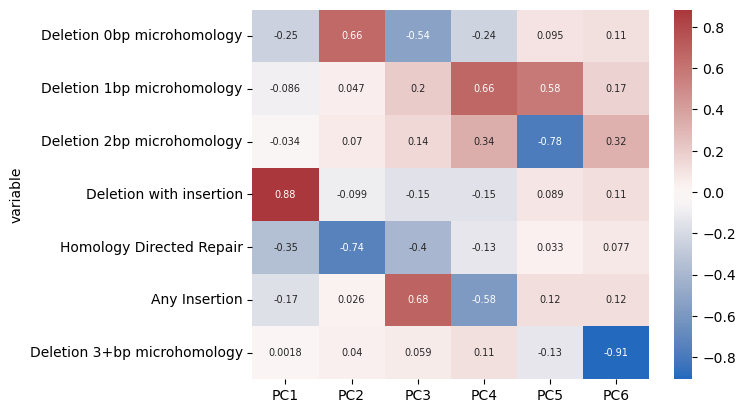

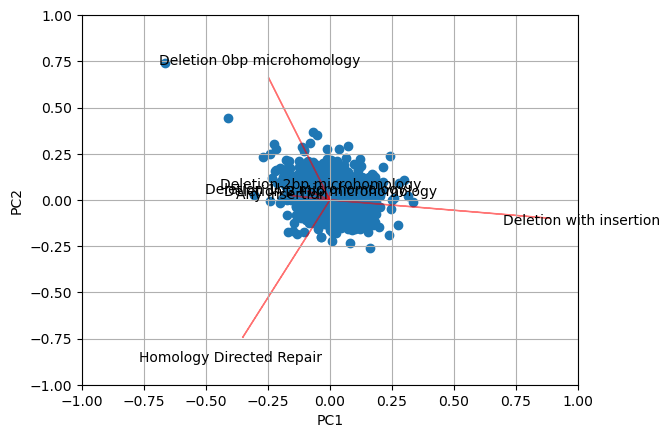

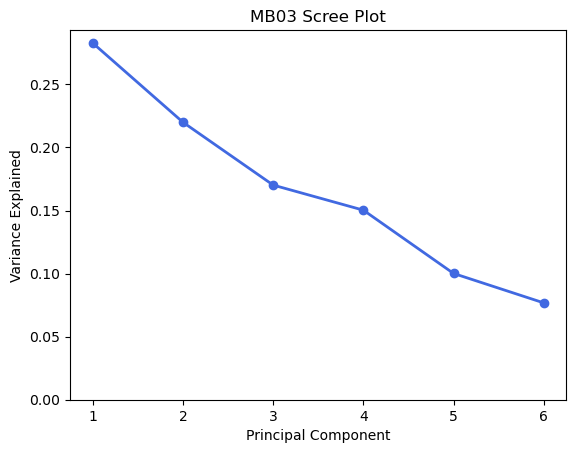

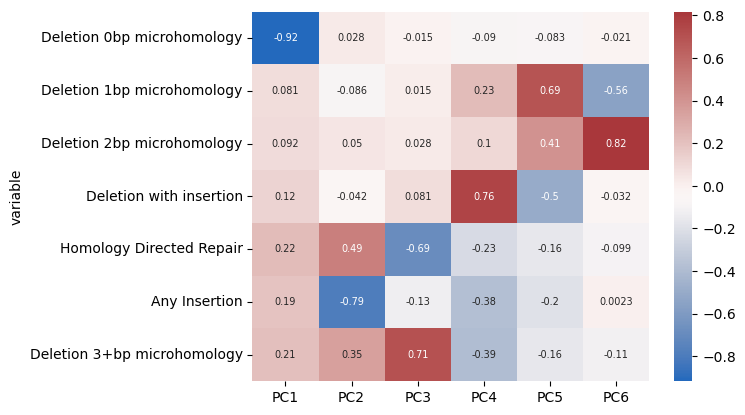

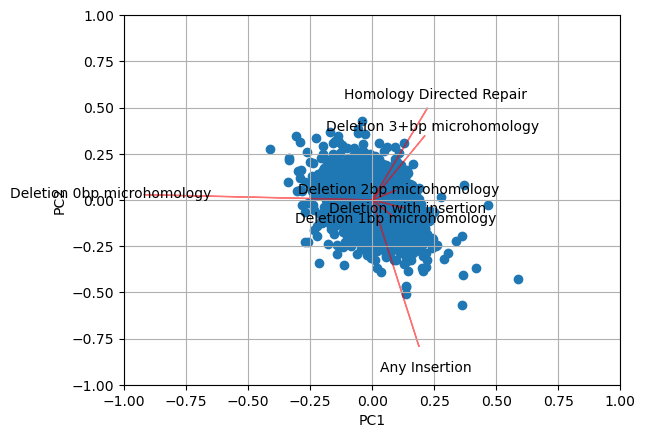

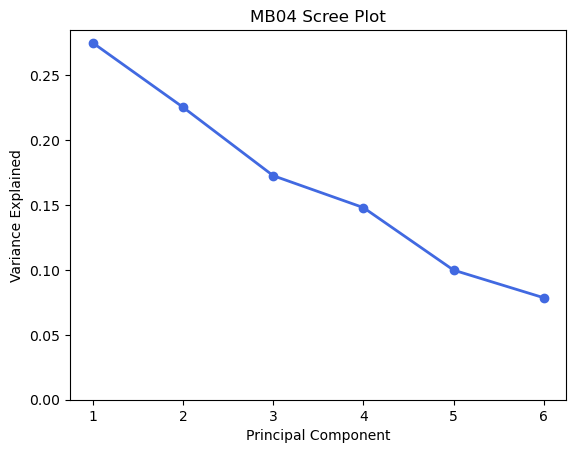

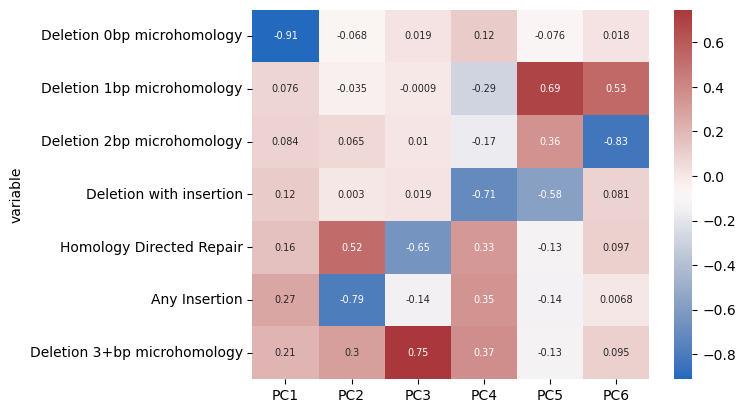

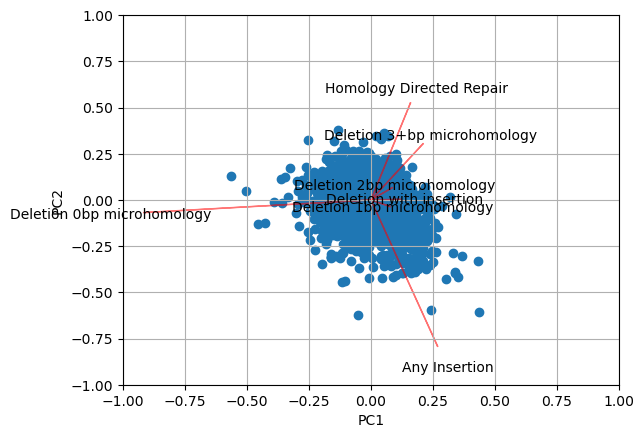

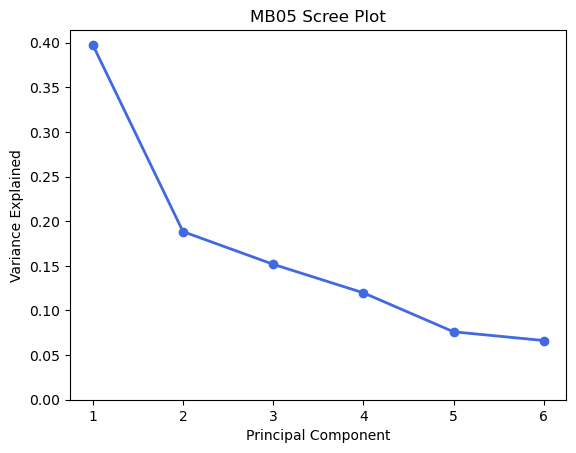

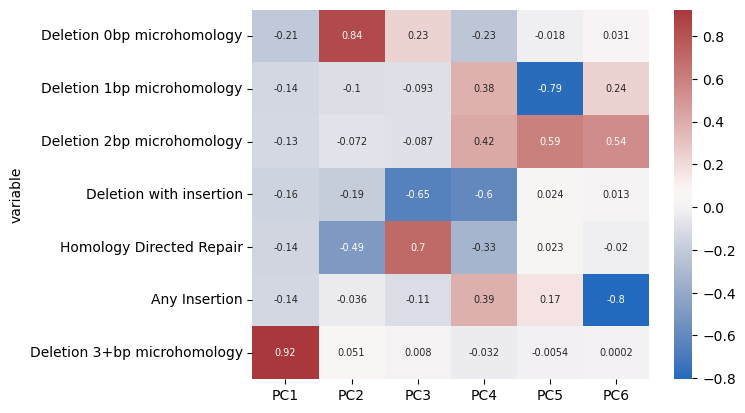

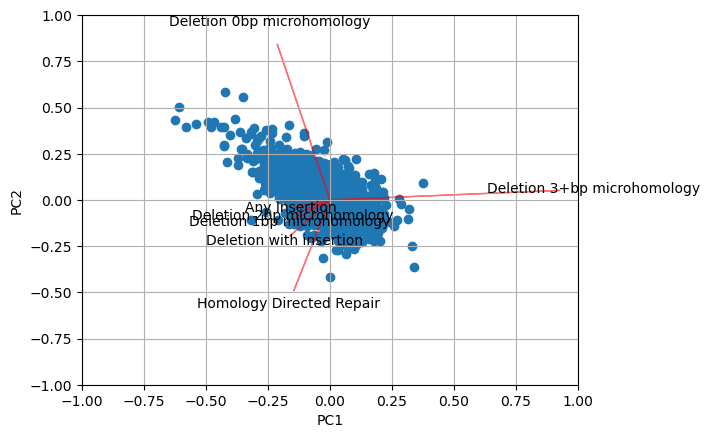

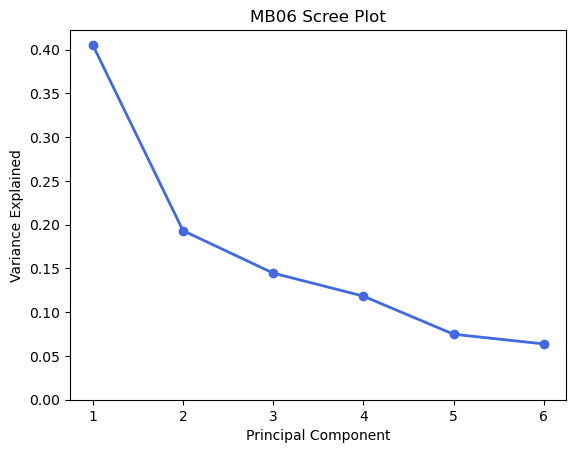

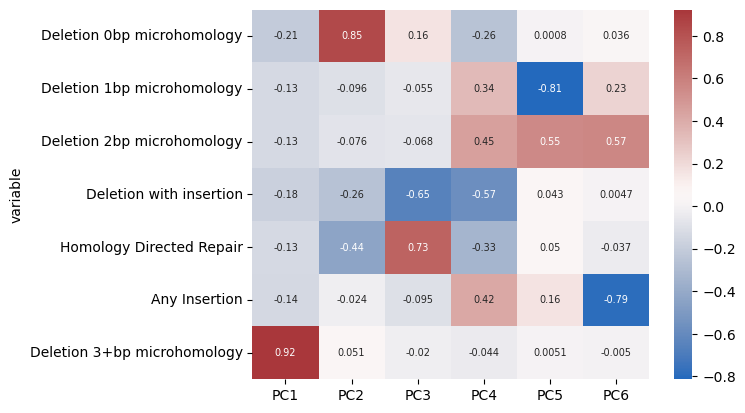

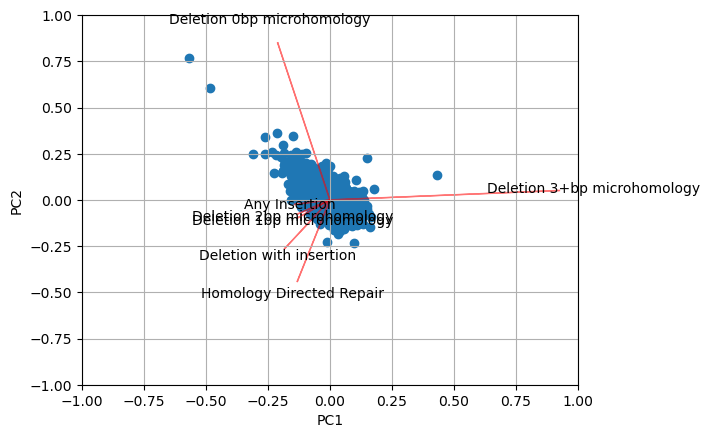

In [ ]:
# Z = {}
results = {}
for alias in aliases:
    # Z[alias] = ilr(X_imputed[alias].values) 
    if METHOD == "robust_cov":
        pca_scores, loadings, explained_variance_ratio, distances, pvalues = logratio_outlier_detection(X_imputed[alias], MinCovDet(random_state=0))
    elif METHOD == "pca":
        pca_scores, loadings, explained_variance_ratio, distances, pvalues = outlier_detection(X_imputed[alias], EmpiricalCovariance())

    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues

    fig, ax = plt.subplots()
    screeplot(explained_variance_ratio, ax, alias)
    plt.savefig("{}/screeplot.{}.png".format(get_experiment_artifacts(profile_type=SAMPLE), alias))
    plt.show()

    loadings_df, z = loadingsplot(loadings, X_imputed[alias].columns.to_list())
    plt.savefig("{}/laodingsplot.{}.png".format(get_experiment_artifacts(profile_type=SAMPLE), alias))
    plt.show()

    #Call the function. Use only the 2 PCs.
    pcs_to_analyse = [0,1]
    biplot(pca_scores[:,pcs_to_analyse], loadings_df.iloc[:,pcs_to_analyse].values, labels=loadings_df.index, components=loadings_df.iloc[:,pcs_to_analyse].columns)
    plt.savefig("{}/biplot.{}.png".format(get_experiment_artifacts(profile_type=SAMPLE), alias))
    plt.show()

In [ ]:
pvalue_dfs = [pd.DataFrame({"pvalues": results[alias][-1],
"distances": results[alias][-2]}, index=X_imputed[alias].index) for alias in aliases]

# FDR correction, removed Thu 16 Feb. Can be applied later to the orignal p-values, do not rerun this code to get FDR correction. Only use final_gene_list.tsv spreadsheet
# for pvalue_df in pvalue_dfs:
#     corrected = fdrcorrection(pvalue_df["pvalues"], alpha=FDR_ALPHA)
#     pvalue_df["reject"] = corrected[0]
#     pvalue_df["pvals_corrected"] = corrected[1]

results_df = pd.concat(pvalue_dfs, axis=1, keys=aliases)
results_df = results_df.join(counts_df.loc[:,["Alias", "Gene", "Counts"]].groupby(['Gene', "Alias"]).median().reset_index().pivot(index="Gene", columns=["Alias"]).reorder_levels([1,0], axis=1)).sort_index(axis=1)
results_df.columns.names = ["Sample", "Measure"]
results_df.head()

Sample           MB01                                               MB02  \
Measure        Counts distances pvals_corrected   pvalues reject  Counts   
Gene                                                                       
0610009B22Rik  2792.0  2.208519             1.0  0.819605  False  3122.0   
0610010K14Rik  2320.5  1.027360             1.0  0.960329  False  2451.0   
0610030E20Rik  1638.0  9.058759             1.0  0.106743  False  2770.0   
0610040J01Rik  1753.0  8.903629             1.0  0.112970  False  1798.0   
1110004F10Rik  1876.0  9.464008             1.0  0.091927  False  1929.0   

Sample                                                     ...    MB05  \
Measure        distances pvals_corrected   pvalues reject  ...  Counts   
Gene                                                       ...           
0610009B22Rik   2.124921             1.0  0.831604  False  ...  3382.0   
0610010K14Rik   0.854783             1.0  0.973408  False  ...  2804.0   
0610030E20Rik   4.471164             1.0  0.483751  False  ...  2109.0   
0610040J01Rik  16.242836             1.0  0.006184  False  ...  2131.5   
1110004F10Rik  17.195650             1.0  0.004143  False  ...  1746.0   

Sample                                                       MB06             \
Measure        distances pvals_corrected   pvalues reject  Counts  distances   
Gene                                                                           
0610009B22Rik   2.800527        1.000000  0.730705  False  3630.0  11.554196   
0610010K14Rik   1.072840        1.000000  0.956479  False  2761.0   3.706510   
0610030E20Rik   2.204513        1.000000  0.820184  False  1886.0   7.641902   
0610040J01Rik  21.849382        0.999907  0.000559  False  1800.0   6.041714   
1110004F10Rik  20.061140        1.000000  0.001217  False  1790.0   5.709531   

Sample                                          
Measure       pvals_corrected   pvalues reject  
Gene                                            
0610009B22Rik             1.0  0.041434  False  
0610010K14Rik             1.0  0.592395  False  
0610030E20Rik             1.0  0.177107  False  
0610040J01Rik             1.0  0.302181  False  
1110004F10Rik             1.0  0.335516  False  

[5 rows x 30 columns]

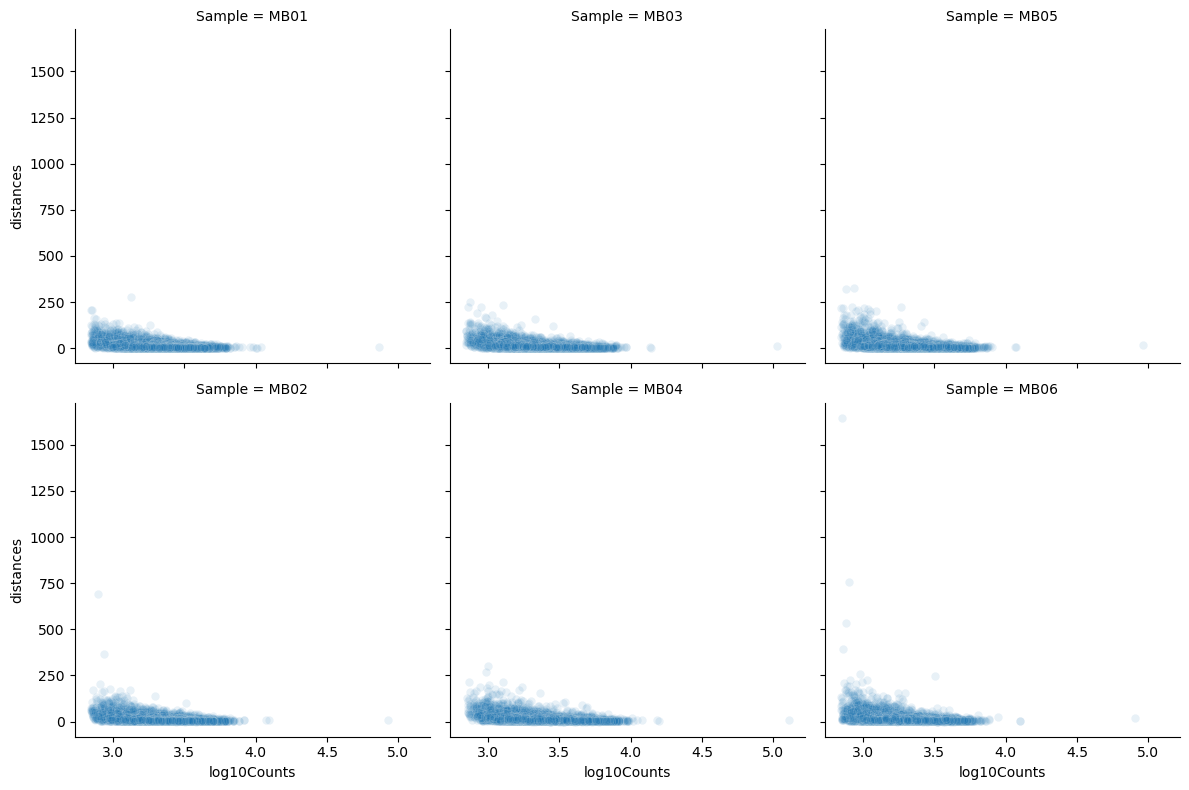

In [ ]:
scatterp_df = results_df.reorder_levels([1,0], axis=1).stack().reset_index()
scatterp_df["log10Counts"] = np.log10(scatterp_df["Counts"])

g = sns.FacetGrid(data=scatterp_df, col="Sample", height = 4, col_wrap=3, col_order=["MB01", "MB03", "MB05", "MB02", "MB04", "MB06" ])

g.map_dataframe(sns.scatterplot, x="log10Counts", y="distances", alpha=0.1)
plt.savefig("{}/countsvsdistance.png".format(get_experiment_artifacts(profile_type=SAMPLE)))


In [ ]:
results_df.to_pickle(get_experiment_artifacts(profile_type=SAMPLE) + "/outlier_results.pkl")
pkl.dump(X_imputed, open("{}/imputed_sample_data.pkl".format(get_experiment_artifacts(profile_type=SAMPLE)), "wb"))